Combined code from both EOG and EMG

In [1]:
import os
import sys
import pandas as pd
from zipfile import ZipFile

import numpy as np
from scipy.signal import butter, filtfilt, welch
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

***We assume that the file app4_dataset.csv is in the same folder as the notebook file***

Standard data manipulation methods below, slightly modified to work in notebook form:

In [ ]:
import os
import pandas as pd
from pathlib import Path
from zipfile import ZipFile
import typer

app = typer.Typer()

@app.command()
def main():
    current_dir = Path.cwd()
    input_zip = current_dir / "app5.zip"
    output_csv = current_dir / "app5_dataset.csv"

    if not input_zip.exists():
        print(f"Error: {input_zip} does not exist.")
        return

    print("Reading zip archive and processing files...")

    data_list = []

    with ZipFile(input_zip, 'r') as zip_ref:
        for file_info in zip_ref.infolist():
            if file_info.filename.endswith(".csv"):
                with zip_ref.open(file_info) as file:
                    df = pd.read_csv(file)
                    
                    # Extract stage and set from the path
                    parts = Path(file_info.filename).parts
                    # parts example: ['Data', 'Train', 'awake', 'file.csv']
                    if len(parts) >= 4:
                        set_type = parts[1]
                        stage = parts[2]
                        filename = parts[3]
                    else:
                        continue  # Skip if unexpected structure
                    
                    df['stage'] = stage
                    df['set'] = set_type
                    df['file'] = filename
                    data_list.append(df)

    if not data_list:
        print("No CSV files found in the archive.")
        return

    full_df = pd.concat(data_list, ignore_index=True)
    full_df.to_csv(output_csv, index=False)

    print(f"Finished. Dataset saved to {output_csv.name}.")

if __name__ == "__main__":
    app()


In [2]:
from pathlib import Path
from typing import Callable, Any, List

import numpy as np
import pandas as pd

from dotenv import load_dotenv
from loguru import logger

# Load environment variables from .env file if it exists
load_dotenv()

# Paths
CURRENT_DIR = Path.cwd()  # For notebooks
logger.info(f"CURRENT_DIR path is: {CURRENT_DIR}")

DATA_FILE = CURRENT_DIR / "app5_dataset.csv"  # CSV in the same folder

def import_app5_dataset() -> pd.DataFrame:
    input_path: Path = DATA_FILE
    df = pd.read_csv(input_path)
    return df

def apply_filter_per_file(df: pd.DataFrame,
                          filter_func: Callable[..., np.ndarray],
                          column: str,
                          **filter_params: Any) -> pd.DataFrame:
    filtered_groups: List[pd.DataFrame] = []

    for file_id, group in df.groupby('file'):
        group = group.copy()
        group[column] = filter_func(group[column].values, **filter_params)
        filtered_groups.append(group)

    return pd.concat(filtered_groups, ignore_index=True)


2025-04-28 00:17:21.111 | INFO     | __main__:<module>:15 - CURRENT_DIR path is: c:\Users\alexa\Documents\Github Repos\dtek2093_sleep_stage_classification\notebooks


Code for bandpass filter

In [3]:
def bandpass_filter(data: np.ndarray, lowcut: float, highcut: float, fs: float, order: int) -> np.ndarray:
    nyq = 0.5 * fs
    b, a = butter(order, [lowcut / nyq, highcut / nyq], btype='band')
    return filtfilt(b, a, data)

Code for feature extraction

In [4]:
from scipy.signal import welch
from scipy.stats import kurtosis, skew, gmean




def extract_freq_features(psd: np.ndarray, freqs: np.ndarray) -> dict:
    # normalize
    psd_norm = psd / (psd.sum() + 1e-10)
    idx_dom = np.argmax(psd)
    # cumulative for roll‑off
    cumsum = np.cumsum(psd_norm)
    rolloff_idx = np.searchsorted(cumsum, 0.85)
    return {
        'dominant_frequency': freqs[idx_dom],
        'spectral_entropy': -np.sum(psd_norm * np.log2(psd_norm + 1e-10)),
        'spectral_bandwidth': np.sqrt(np.sum(((freqs - freqs[idx_dom])**2) * psd_norm)),
        'spectral_centroid': np.sum(freqs * psd_norm),
        'spectral_rolloff': freqs[min(rolloff_idx, len(freqs)-1)],
        'spectral_flatness': gmean(psd + 1e-10) / (psd.mean() + 1e-10)
    }

def extract_features(signal: np.ndarray, fs: float) -> dict:
    # time‑domain
    feat = {
        'mean': signal.mean(),
        'std': signal.std(),
        'min': signal.min(),
        'max': signal.max(),
        'median': np.median(signal),
        'energy': np.sum(signal**2),
        'kurtosis': kurtosis(signal),
        'skewness': skew(signal)
    }
    # overall freq‑domain
    freqs, psd = welch(signal, fs, nperseg=min(256, len(signal)))
    feat.update(extract_freq_features(psd, freqs))
    return feat

def extract_multiband_features(signal: np.ndarray, fs: float, signal_column : str) -> dict:
    # define your five bands (Hz)
    if signal_column == 'eog':
        bands = {
            'b1': (0.5, 2.0),
            'b2': (2.0, 4.0),
            'b3': (4.0, 7.0),
            'b4': (7.0, 10.0),
            'b5': (10.0, 15.0),
        }
    elif signal_column == 'emg':
        # EMG bands within 20–99 Hz (five equal-width bands)
        bands= {
            'b1': (20.0, 36.0),
            'b2': (36.0, 52.0),
            'b3': (52.0, 68.0),
            'b4': (68.0, 84.0),
            'b5': (84.0, 99.0),
        }
    all_feat = {}
    # first, global features
    all_feat.update(extract_features(signal, fs))
    # then each band
    for name, (low, high) in bands.items():
        sig_f = bandpass_filter(signal, low, high, fs, order=4)
        sub_feat = extract_features(sig_f, fs)
        # prefix keys with band name
        for k, v in sub_feat.items():
            all_feat[f'{name}_{k}'] = v
    return all_feat

def extract_features_and_labels(df: pd.DataFrame,
                                signal_column: str,
                                label_column: str,
                                fs: float=200,
                                multiband = True) -> (pd.DataFrame, pd.Series):
    feats, labels = [], []
    for file_id, grp in df.groupby('file'):
        sig = grp[signal_column].values
        if multiband:
            feats.append(extract_multiband_features(sig, fs, signal_column))
        else:
            feats.append(extract_features(sig, fs))
        labels.append(grp[label_column].iat[0])
    return pd.DataFrame(feats), pd.Series(labels, name=label_column)



Code for random forest

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV


def train_eog_random_forest(X_train: pd.DataFrame, y_train: pd.Series):
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    return rf


def recursive_feature_elimination(rf: RandomForestClassifier, X_train: pd.DataFrame, y_train: pd.Series) -> RFECV:
    rfecv = RFECV(
        estimator=rf,
        step=1,
        cv=StratifiedKFold(5),
        scoring='accuracy',
        n_jobs=-1
    )
    rfecv.fit(X_train, y_train)
    print("Optimal features:", rfecv.n_features_)
    return rfecv


def find_best_rf_hyperparameters(X_train: pd.DataFrame, y_train: pd.Series):
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    rf = RandomForestClassifier(random_state=42)
    feature_eliminator = recursive_feature_elimination(rf, X_train, y_train)
    X_train = feature_eliminator.transform(X_train)
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)
    best_rf = grid_search.best_estimator_
    return best_rf, feature_eliminator


def eval_eog_random_forest(rf: RandomForestClassifier, le: LabelEncoder, X_test: pd.DataFrame, y_test: pd.Series):
    predictions = rf.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    report = classification_report(y_test, predictions, target_names=le.classes_)
    return accuracy, report, y_test, predictions


def train_and_eval_eog_random_forest(features: pd.DataFrame, labels: pd.DataFrame):
    le = LabelEncoder()
    labels = labels.values.ravel()
    labels_encoded = le.fit_transform(labels)
    X_train, X_test, y_train, y_test = train_test_split(features, labels_encoded, test_size=0.3, random_state=42)

    rf, feature_eliminator = find_best_rf_hyperparameters(X_train, y_train)

    X_test = feature_eliminator.transform(X_test)

    accuracy, report, y_test, predictions = eval_eog_random_forest(rf, le, X_test, y_test)

    return accuracy, report, y_test, predictions


Code for SVM

In [28]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.feature_selection import RFECV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV


def train_eog_svm(X_train: pd.DataFrame, y_train: pd.Series):
    svm = SVC(kernel='rbf', random_state=42)
    svm.fit(X_train, y_train)
    return svm


def recursive_feature_elimination_svm(svm: SVC, X_train: pd.DataFrame, y_train: pd.Series) -> RFECV:
    rfecv = RFECV(
        estimator=svm,
        step=1,
        cv=StratifiedKFold(5),
        scoring='accuracy',
        n_jobs=-1
    )
    rfecv.fit(X_train, y_train)
    print("Optimal features:", rfecv.n_features_)
    return rfecv


def find_best_svm_hyperparameters(X_train: pd.DataFrame, y_train: pd.Series):
    param_grid = {
        'C': [0.1, 1, 10],
        'gamma': ['scale', 'auto', 0.01, 0.001],
        'kernel': ['rbf', 'linear']
    }
    svm = SVC(random_state=42)
    grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)
    best_svm = grid_search.best_estimator_
    return best_svm, None  # No feature elimination




def eval_eog_svm(svm: SVC, le: LabelEncoder, X_test: pd.DataFrame, y_test: pd.Series):
    predictions = svm.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    report = classification_report(y_test, predictions, target_names=le.classes_)
    return accuracy, report, y_test, predictions


def train_and_eval_eog_svm(features: pd.DataFrame, labels: pd.DataFrame):
    le = LabelEncoder()
    labels = labels.values.ravel()
    labels_encoded = le.fit_transform(labels)

    X_train, X_test, y_train, y_test = train_test_split(features, labels_encoded, test_size=0.3, random_state=42)

    svm, feature_eliminator = find_best_svm_hyperparameters(X_train, y_train)

    if feature_eliminator is not None:
        X_test = feature_eliminator.transform(X_test)

    accuracy, report, y_test, predictions = eval_eog_svm(svm, le, X_test, y_test)

    return accuracy, report, y_test, predictions



Now we start calling the methods above. First we import everything into a DF.

In [7]:
df = import_app5_dataset()
df = df.dropna(subset=['emg'])
df = df.dropna(subset=['eog'])
# Show a preview
print(df.head())

    eog  emg  stage    set           file
0  39.0  3.0  awake  Train  0_subj_10.csv
1  36.0  4.0  awake  Train  0_subj_10.csv
2  36.0  2.0  awake  Train  0_subj_10.csv
3  40.0 -5.0  awake  Train  0_subj_10.csv
4  46.0 -2.0  awake  Train  0_subj_10.csv


Then we apply filtering to both signals

In [8]:
df = apply_filter_per_file(df, bandpass_filter, column='eog', lowcut=0.5, highcut=50, fs=200, order=4)
df = apply_filter_per_file(df, bandpass_filter, column='emg', lowcut=20, highcut=99, fs=200, order=4)
print(df.head())

        eog       emg   stage    set          file
0  1.158572  0.015736  nonrem  Train  0_subj_1.csv
1  6.277940  4.449334  nonrem  Train  0_subj_1.csv
2  8.120397 -2.208466  nonrem  Train  0_subj_1.csv
3  6.385139 -3.317598  nonrem  Train  0_subj_1.csv
4  3.723779  5.086204  nonrem  Train  0_subj_1.csv


Time for some plots, We plot the first unique file, already filtered

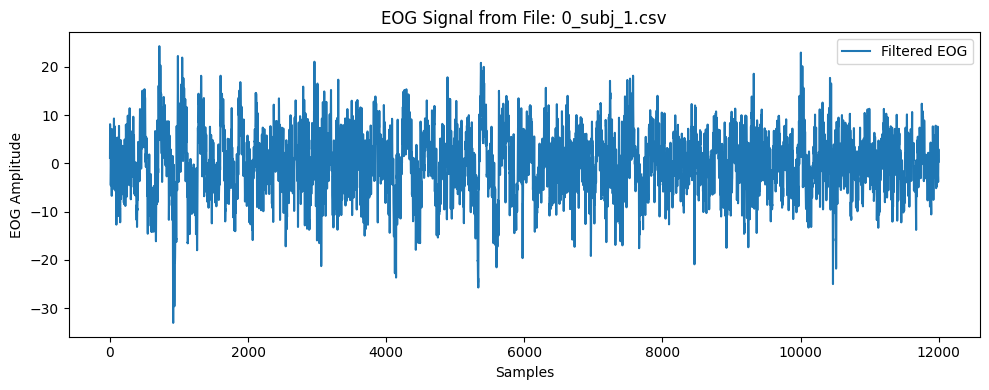

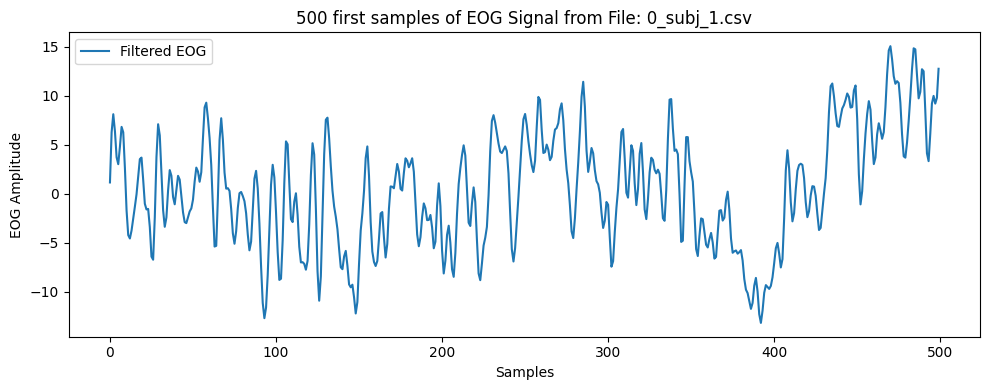

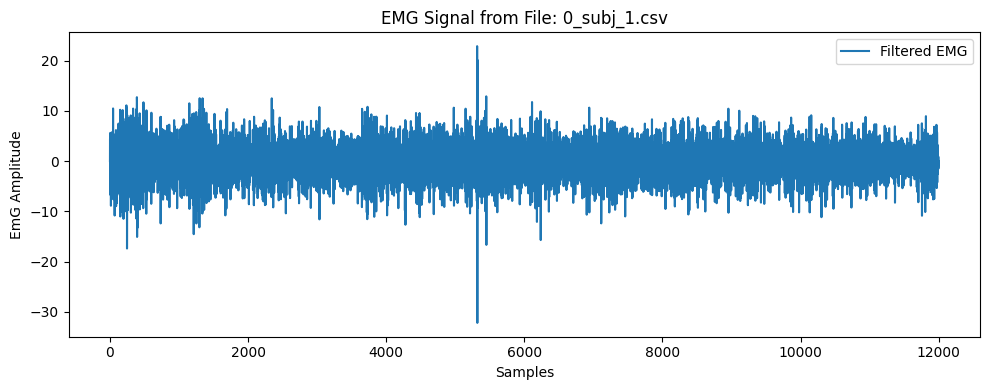

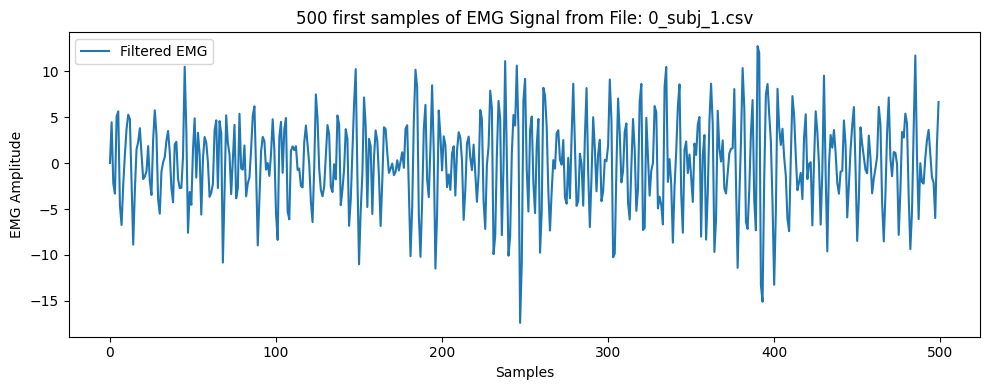

In [9]:
# Choose one file (using the first unique file as an example)
file_id = df['file'].unique()[0]
file_data = df[df['file'] == file_id]

plt.figure(figsize=(10, 4))
plt.plot(file_data.index, file_data['eog'], label='Filtered EOG')
plt.title(f'EOG Signal from File: {file_id}')
plt.xlabel('Samples')
plt.ylabel('EOG Amplitude')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(file_data.index[:500], file_data['eog'][:500], label='Filtered EOG')
plt.title(f'500 first samples of EOG Signal from File: {file_id}')
plt.xlabel('Samples')
plt.ylabel('EOG Amplitude')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(file_data.index, file_data['emg'], label='Filtered EMG')
plt.title(f'EMG Signal from File: {file_id}')
plt.xlabel('Samples')
plt.ylabel('EmG Amplitude')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(file_data.index[:500], file_data['emg'][:500], label='Filtered EMG')
plt.title(f'500 first samples of EMG Signal from File: {file_id}')
plt.xlabel('Samples')
plt.ylabel('EMG Amplitude')
plt.legend()
plt.tight_layout()
plt.show()

We will plot the PSDs for the same filtered files as above

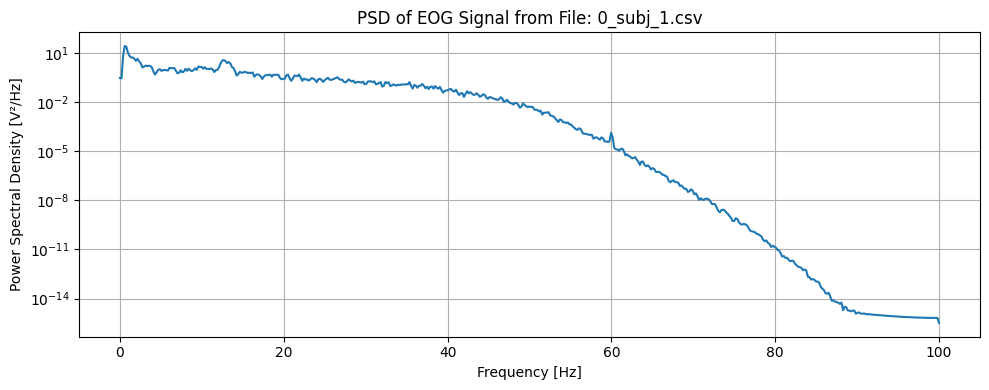

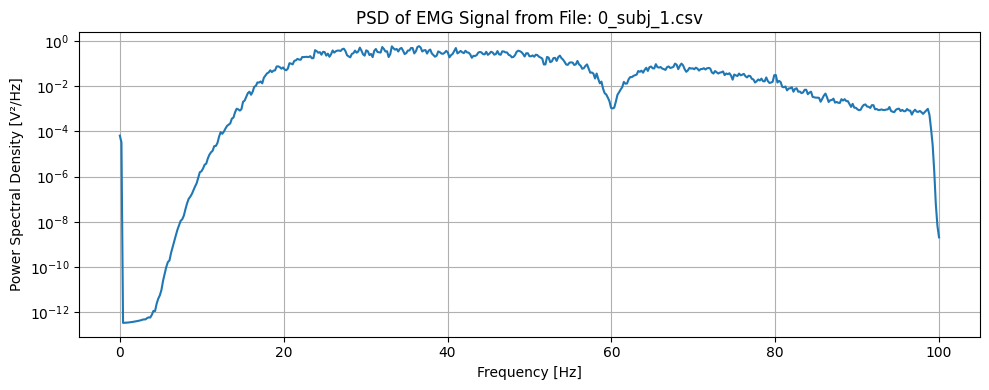

In [10]:
# Sampling frequency
fs = 200  # <-- Replace this with your real sampling frequency if you know it!

# EOG PSD
f_eog, Pxx_eog = welch(file_data['eog'], fs=fs, nperseg=1024)

plt.figure(figsize=(10, 4))
plt.semilogy(f_eog, Pxx_eog)  # semilogy = log scale on y-axis (standard for PSD)
plt.title(f'PSD of EOG Signal from File: {file_id}')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power Spectral Density [V²/Hz]')
plt.grid()
plt.tight_layout()
plt.show()

# EMG PSD
f_emg, Pxx_emg = welch(file_data['emg'], fs=fs, nperseg=1024)

plt.figure(figsize=(10, 4))
plt.semilogy(f_emg, Pxx_emg)
plt.title(f'PSD of EMG Signal from File: {file_id}')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power Spectral Density [V²/Hz]')
plt.grid()
plt.tight_layout()
plt.show()

Next, we extract features!

In [11]:
# Extract features per file from your full_df (which contains columns 'file', 'stage', and cleaned 'eog')
features_eog, labels_eog = extract_features_and_labels(df, signal_column='eog', label_column='stage')
features_emg, labels_emg = extract_features_and_labels(df, signal_column='emg', label_column='stage')
features = features_eog.join(features_emg, lsuffix='_eog', rsuffix='_emg')
labels = labels_eog

Now we run the training and evaluation with the Random Forest method!

Optimal features: 115
Fitting 3 folds for each of 81 candidates, totalling 243 fits
Random Forest - Accuracy: 0.8162393162393162
Random Forest - Classification Report:
               precision    recall  f1-score   support

       awake       0.94      0.79      0.86        99
      nonrem       0.68      0.90      0.78        73
         rem       0.87      0.76      0.81        62

    accuracy                           0.82       234
   macro avg       0.83      0.82      0.81       234
weighted avg       0.84      0.82      0.82       234



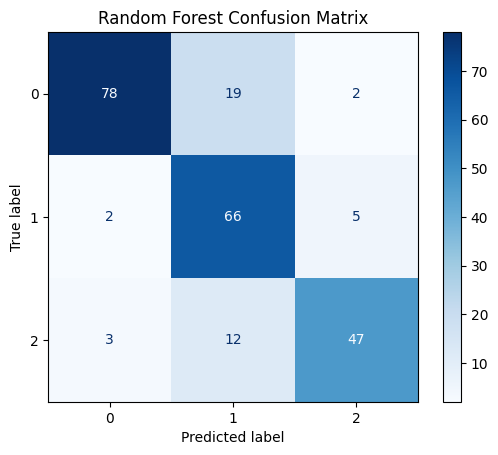

In [16]:
# Evaluate Random Forest on the test set
accuracy, report, y_true, y_pred = train_and_eval_eog_random_forest(features, labels)

print("Random Forest - Accuracy:", accuracy)
print("Random Forest - Classification Report:\n", report)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Generate label list automatically from the true labels
your_label_list = sorted(np.unique(y_true))

# Confusion Matrix for Random Forest
cm = confusion_matrix(y_true, y_pred, labels=your_label_list)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=your_label_list)
disp.plot(cmap='Blues')
plt.title('Random Forest Confusion Matrix')
plt.show()


Now we run the training and evaluation with the SVM method!

**Warning! VERY slow!**

In [ ]:
accuracy_svm, report_svm, y_true_svm, y_pred_svm = train_and_eval_eog_svm(features, labels)

print("SVM - Accuracy:", accuracy_svm)
print("SVM - Classification Report:\n", report_svm)

# Plot confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

label_list_svm = sorted(np.unique(y_true_svm))
cm_svm = confusion_matrix(y_true_svm, y_pred_svm, labels=label_list_svm)
disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=label_list_svm)
disp_svm.plot(cmap='Purples')
plt.title('SVM Confusion Matrix')
plt.show()


Fitting 3 folds for each of 24 candidates, totalling 72 fits
